# Gene Expression Profiles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

sns.set()

## Gene Expression Profiles
----
Consideration of an Alternative Question: Genetic Predictors
Rather than creating a predictive model of diagnosis using various types of patient information, we had previously considered developing a model from the detailed biological data available to consider the importance of genes on chromosome 21 in Alzheimer’s Disease. Chromosome 21 is known to be very important in the etiology of AD - for example, over half of those born with an extra copy of Chr21 (a condition known as Down’s Syndrome) will go on to develop Alzheimer’s Disease [1]. While it is commonly said that the link between Chr21 and AD is due to the gene for the Amyloid Precursor Protein (APP) [2], there are many other genes on this chromosome that have also been linked to Alzheimer’s disease [3].
Of the wealth of genetic data that ADNI publishes, we drew primarily on the microarray gene expression profile dataset, which used ~50,000 genetic probes to assess the activity of genes across the genome. The outcome for each patient in the gene profile dataset was determined using the ADNIMerge dataset. To identify only chromosome 21 genes, the Affymetrix gene annotation dataset was used to annotate the gene expression data set with chromosomal location of the target gene for every probe. The combination of these three datasets created the possibility of building a model based on the genes of any chromosome to predict any clinical outcome. The preliminary models (discussed below) suggested little promise of interesting results to be derived from considering gene expression data in isolation, so we ultimately decided to focus on a more general predictive model involving more feature types instead.


**Sources**

[1] https://www.nia.nih.gov/health/alzheimers-disease-people-down-syndrome

[2] https://www.alz.org/alzheimers-dementia/what-is-dementia/types-of-dementia/down-syndrome

[3] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4019841/

https://www.ncbi.nlm.nih.gov/pubmed/18199027


http://www.bbc.com/future/story/20181022-there-is-mounting-evidence-that-herpes-leads-to-alzheimers





To determine the chromosomal location and biological role of any gene, we used this [gene annotation database provided by affymetrix](http://www.affymetrix.com/support/technical/byproduct.affx?product=HG-U219). Using this database, we can add columns to the gene expression profile dataset for the chromosomal column and gene name of every gene. From this, we can isolate genes based on their chromosomal location.

In [2]:
annote = pd.read_csv("excel_annotations.csv", skiprows = 25)

In [3]:
dropcolumns = ['GeneChip Array','Species Scientific Name','Annotation Date','Sequence Type','Sequence Source',
               'Transcript ID(Array Design)','Target Description','Representative Public ID',
               'Archival UniGene Cluster','Genome Version','Unigene Cluster Type','Ensembl','EC','OMIM',
              'FlyBase','AGI','WormBase','MGI Name','RGD Name','SGD accession number','QTL','Annotation Description',
              'Annotation Transcript Cluster','Transcript Assignments','Annotation Notes']

In [4]:
annote = annote.drop(dropcolumns, axis = 1)

In [5]:
Chromosome = []
for item in annote["Chromosomal Location"]:
    Chromosome.append(item.replace("chr","").replace('cen','').replace('-','').replace('p','q').split('q')[0])
annote['Chromosome']=Chromosome

In [7]:
print("Chromosome 21 genes present in gene expression profile dataset: ",sum(annote['Chromosome']=='21'))


Chromosome 21 genes present in gene expression profile dataset:  609


In [8]:
# low_memory = False allows mixed data types without a warning
GEP_df = pd.read_csv("ADNI_Gene_Expression_Profile.csv", low_memory=False, index_col = 'Phase')

# make subject ID the column head, move previous column head in place of subject ID:
ID_column = GEP_df.iloc[1].copy().values 
ID_column[0] = 'LocusLink'
ID_column[1] = 'Symbol'
GEP_df.iloc[1] = GEP_df.columns
GEP_df.columns = ID_column
GEP_df.rename(index={'SubjectID':'Phase'}, inplace=True)

# add correct index and column names
GEP_df = GEP_df.rename_axis("Gene_PSID")
GEP_df = GEP_df.rename_axis("SubjectID", axis = 'columns')

# replace some unnecessary information 'Unnamed 1', 'Unnamed2'
GEP_df.loc['Phase'][0] = np.nan
GEP_df.loc['Phase'][1] = np.nan

# drop redundant probeset row:
GEP_df.drop(['ProbeSet'])

# rename final column correctly:
nan = GEP_df.columns[-1]
GEP_df = GEP_df.rename(columns={nan:'Biological Name'})


In [10]:
chrlist = [0]*len(GEP_df.index)
for i, gene in enumerate(GEP_df.index):
    gene_id = gene
    try:
        gene_ch = annote[annote['Probe Set ID']==gene_id]['Chromosome'].values[0]
        chrlist[i] = gene_ch
    except IndexError:
        chrlist[i] = np.nan

In [11]:
GEP_df['Chromosome'] = chrlist

### Chromosome 21 Dataset

In [16]:
GEP_head = GEP_df.iloc[0:8]
GEP_data = GEP_df.iloc[8:]
c21 = GEP_data[GEP_data['Chromosome']=='21']
GEP_C21 = pd.concat((GEP_head,c21))

display(GEP_C21.head(15))

SubjectID,LocusLink,Symbol,116_S_1249,037_S_4410,006_S_4153,116_S_1232,099_S_4205,007_S_4467,128_S_0205,003_S_2374,...,014_S_4668,130_S_0289,141_S_4456,009_S_2381,053_S_4557,073_S_4300,041_S_4014,007_S_0101,Biological Name,Chromosome
Gene_PSID,,,,,,,,,,,,,,,,,,,,,
Visit,NaN,NaN,m48,v03,v03,m48,v03,v03,v06,bl,...,v03,m60,v03,bl,v03,v03,v03,v06,NaN,NaN
Phase,NaN,NaN,ADNIGO,ADNI2,ADNI2.1,ADNIGO.1,ADNI2.2,ADNI2.3,ADNI2.4,ADNIGO.2,...,ADNI2.443,ADNIGO.293,ADNI2.444,ADNIGO.294,ADNI2.445,ADNI2.446,ADNI2.447,ADNI2.448,Unnamed: 747,NaN
260/280,NaN,NaN,2.05,2.07,2.04,2.03,2.01,2.05,1.95,1.99,...,2.05,1.98,2.09,1.87,2.03,2.11,1.94,2.06,NaN,NaN
260/230,NaN,NaN,0.55,1.54,2.1,1.52,1.6,1.91,1.47,2.07,...,2.05,1.65,1.56,1.45,1.33,0.27,1.72,1.35,NaN,NaN
RIN,NaN,NaN,7.7,7.6,7.2,6.8,7.9,7,7.9,7.2,...,6.5,6.3,6.4,6.6,6.8,6.2,5.8,6.7,NaN,NaN
Affy Plate,NaN,NaN,7,3,6,7,9,4,3,8,...,6,9,3,8,5,3,1,4,NaN,NaN
YearofCollection,NaN,NaN,2011,2012,2011,2011,2011,2012,2011,2011,...,2012,2011,2012,2011,2012,2011,2011,2012,NaN,NaN
ProbeSet,LocusLink,Symbol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11715130_s_at,LOC337967,KRTAP6-2,2.424,2.623,2.501,3.103,2.567,2.992,2.249,2.63,...,3.074,2.763,2.89,3.155,2.526,2.452,2.822,2.651,[KRTAP6-2] keratin associated protein 6-2,21


In [18]:
adni_df = pd.read_csv("ADNIMERGE.csv", low_memory=False)

In [19]:
keep_columns = ['PTID','DX','Month']
outcome_df = adni_df[keep_columns]

In [20]:
"""
if any diagnoses are dementia, report dementia - if all diagnoses ara NaN, report NaN.
"""


n = len(GEP_C21.columns[2:-2])
target = np.full(n,0)
for i, col in enumerate(GEP_C21.columns[2:-2]):
    if (outcome_df[outcome_df['PTID']==col]['DX'] == 'Dementia').any():
        target[i] = 1
    elif (pd.Series([str(o) == 'nan' for o in outcome_df[outcome_df['PTID']==col]['DX']])).all():
        target[i] = np.nan


From this dataset, we find 13 features corresponding to probes of the APP gene, a major implicated gene in Alzheimer's Disease. 

To analyse the role of different genes on chromosome 21 in the etiology of Alzheimer's Disease, a good baseline model would be to use these 13 features in a simple baseline model, so we fitted a simple logistic regression to an X data set of these 13 features.

To ensure that imbalance in the data was not an issue, we used Synthetic Minority Over-sampling Technique (SMOTE) using the imblearn package.

In [27]:
APP_PSID = annote[annote['Gene Symbol'] == 'APP']['Probe Set ID'].values

no_markers = len(APP_PSID)
no_patients = len(GEP_C21.columns[2:-2])

In [28]:
X = np.zeros((no_patients,no_markers))

for i, col in enumerate(GEP_C21.columns[2:-2]):
    patient = GEP_C21[col]
    for j, PSID in enumerate(APP_PSID):
        X[i,j] = patient[PSID]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)

In [30]:
sm =SMOTE(ratio=1, random_state=42)
X_TR, y_TR = sm.fit_resample(X_train,y_train)

In [31]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

In [32]:
logreg = LogisticRegressionCV(cv=5, max_iter=10000).fit(X_TR,y_TR)

In [36]:
app_crossvalscore = np.mean(cross_val_score(logreg,X_TR,y_TR, cv=5))

In [35]:
app_testscore = accuracy_score(logreg.predict(X_test),y_test)

The cross-validation and test scores for this baseline model are:

In [38]:
print("Cross-validation score ",app_crossvalscore)
print("Test score ",app_testscore)

Cross-validation score  0.5798706240487063
Test score  0.5178571428571429


Both appear only marginally better than random. APP gene expression profile appears to be a very poor predictor of AD.

Next, we looked to build a similar simplistic model using all genes on chromosome 21 to see whether there was anything in particular that stood out as interesting.

In [39]:
PSIDs = GEP_C21.index[8:].values

no_markers2 = len(PSIDs)
no_patients2 = len(GEP_C21.columns[2:-2])


In [40]:
X2 = np.zeros((no_patients2,no_markers2))

for i, col in enumerate(GEP_C21.columns[2:-2]):
    patient = GEP_C21[col]
    for j, PSID in enumerate(PSIDs):
        X2[i,j] = patient[PSID]



In [41]:
X_tra, X_tst, y_tra, y_tst = train_test_split(X2,target, test_size=0.3, random_state=42)

In [42]:
sm = SMOTE(ratio=1, random_state=42)
X_TR2, y_TR2 = sm.fit_resample(X_tra,y_tra)

In [43]:
logreg2 = LogisticRegressionCV(cv=5, max_iter=10000).fit(X_TR2,y_TR2)

In [45]:
c21_crossvalscore = np.mean(cross_val_score(logreg2,X_TR2,y_TR2, cv=5))

In [46]:
c21_testscore = np.mean(cross_val_score(logreg2,X_tst,y_tst, cv=5))

The results of this are:

In [48]:
print("Cross-validation score ",c21_crossvalscore)
print("Test score ",c21_testscore)

Cross-validation score  0.8115677321156773
Test score  0.6965041721563461


These results are slightly more promising, and warrant an investigation into the details of the model: what are the genes with the largest magnitude associated coefficient?

In [55]:
big = np.argmax(logreg2.coef_)
small = np.argmin(logreg2.coef_)
big_gene = PSIDs[big]
small_gene = PSIDs[small]

In [60]:
print("Biggest positive coefficient: ")
annote[annote['Probe Set ID']==big_gene]

Biggest positive coefficient: 


,Probe Set ID,UniGene ID,Alignments,Gene Title,Gene Symbol,Chromosomal Location,Entrez Gene,SwissProt,RefSeq Protein ID,RefSeq Transcript ID,Gene Ontology Biological Process,Gene Ontology Cellular Component,Gene Ontology Molecular Function,Pathway,InterPro,Trans Membrane,Chromosome
133,11715233_s_at,Hs.381214,chr21:47581062-47604373 (-) // 95.94 // q22.3,spermatogenesis and centriole associated 1-like,SPATC1L,chr21q22.3,84221,Q9H0A9,NP_001136326 /// NP_115637 /// XP_005261245 //...,NM_001142854 /// NM_032261 /// XM_005261188 //...,---,---,0005515 // protein binding // inferred from ph...,---,"IPR029384 // Speriolin, C-terminal // 1.0E-75 ...",---,21


In [61]:
print("Biggest negative coefficient: ")
annote[annote['Probe Set ID']==small_gene]

Biggest negative coefficient: 


,Probe Set ID,UniGene ID,Alignments,Gene Title,Gene Symbol,Chromosomal Location,Entrez Gene,SwissProt,RefSeq Protein ID,RefSeq Transcript ID,Gene Ontology Biological Process,Gene Ontology Cellular Component,Gene Ontology Molecular Function,Pathway,InterPro,Trans Membrane,Chromosome
8325,11723425_at,Hs.529400,chr21:34697208-34732236 (+) // 82.3 // q22.11,"interferon (alpha, beta and omega) receptor 1",IFNAR1,chr21q22.11,3454,P17181,NP_000620 /// XP_005261021 /// XP_011527854,NM_000629 /// XM_005260964 /// XM_011529552,0007166 // cell surface receptor signaling pat...,0005622 // intracellular // traceable author s...,0004904 // interferon receptor activity // inf...,---,IPR003961 // Fibronectin type III // 2.1E-35 /...,---,21


Here, the gene with the largest positive coefficient in this model has no identified link with cognitive function, autophagy, protein synthesis, calcium signalling, immune system, inflammation or any other process linked with neurodegenerative disease - and is only moderately expressed in the brain. Moreover, the gene with the strongest negative coefficient has actually been previously been positively linked with amyloidogenesis in mice, contrary to what our model might imply.

This suggests that there may be limited immediate benefit to using gene expression profile data. To further consider this, we plotted the gene expression distribution for all 13 APP gene probes and also the gene probe found to be the strongest predictor for our model - we see no clear difference in distribution between AD and non-AD, implying again that gene expression data may not be as useful as first thought.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


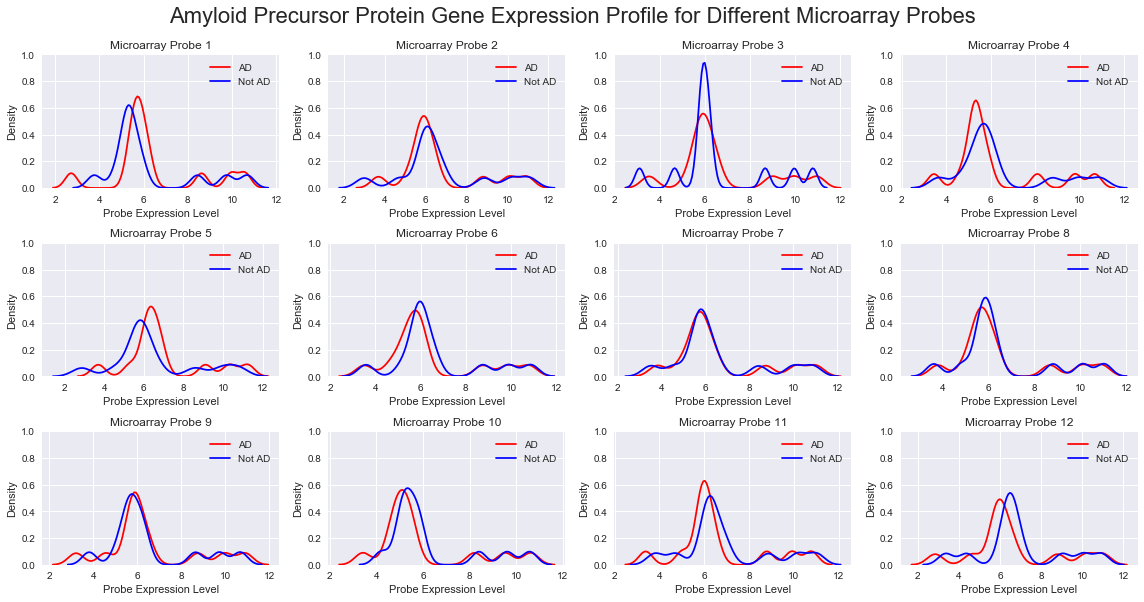

In [69]:
xpos = X_TR[y_TR==1]
xneg = X_TR[y_TR==0]
plt.subplots(3,4, figsize=(16,8))
plt.suptitle("Amyloid Precursor Protein Gene Expression Profile for Different Microarray Probes", y=1.04, fontsize =22)
for i in range(12):
    ax = plt.subplot(3,4,i+1)
    ax.set_title("Microarray Probe {0}".format(str(i+1)))
    sns.distplot(xpos[i], bins=30, color = 'red', ax = ax, hist=False, label = "AD")
    sns.distplot(xneg[i], bins=30, color = 'blue', ax = ax, hist=False, label = 'Not AD')
    ax.set_xlabel("Probe Expression Level")
    ax.set_ylabel("Density")
    ax.set_ylim((0,1))
plt.tight_layout()
plt.show()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


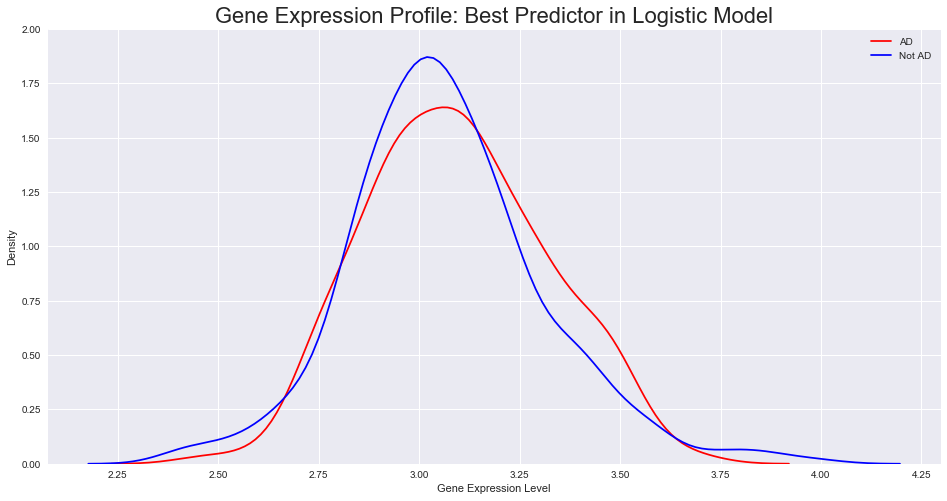

In [70]:
bigboy = X_TR2[:,13]

bigyes = bigboy[y_TR2==1]
bignah = bigboy[y_TR2==0]
plt.figure(figsize=(16,8))
sns.distplot(bigyes, bins=30, color = 'red', hist=False, label = "AD")
sns.distplot(bignah, bins=30, color = 'blue', hist=False, label = 'Not AD')
plt.title("Gene Expression Profile: Best Predictor in Logistic Model", fontsize=22)
plt.ylim((0,2))
plt.xlabel("Gene Expression Level")
plt.ylabel("Density")
plt.show()

When researching details of the gene expression dataset, it was found the the samples from which the data is derived were taken from blood, not the central nervous system. This means that the gene expression profiles are not indicative of the cellular environment in the brain, as the gene expression profiles of different tissues varies hugely and the central nervous system is separated from the rest of the body by a near-impervious blood-brain-barrier. As such, even though other models could be tested and different chromosomes could be examined, it was decided that the chance of finding valuable data was too low, and as such the group focussed on other aims.